## PFSA


In [77]:
import matplotlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import argparse
from pathlib import Path
from scipy import stats

plt.rcParams["font.family"] = "Times New Roman"


def get_experiment_name(x):
    """Extract experiment name from grammar name."""
    return x.split("_")[0]


def get_seed(x):
    """Extract seed from grammar name if it exists."""
    if "seed" in x:
        return int(re.search(r"seed(\d+)", x).group(1))
    return None


def get_window(x):
    """Extract window size from grammar name if it exists."""
    if "window" in x:
        return int(re.search(r"window(\d+)", x).group(1))
    return None


def plot_entropy_distributions(df):
    """Plot local and global entropy distributions."""
    # Prepare data
    local_entropy_cols = [f"{m}_local_entropy" for m in [2, 3, 4, 5]]
    local_entropy_data = df[local_entropy_cols]
    global_entropy_data = df[["next_symbol_entropy"]]

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot local entropy distributions
    sns.swarmplot(data=local_entropy_data, ax=ax1, size=8, alpha=0.6)
    sns.boxplot(
        data=local_entropy_data,
        ax=ax1,
        color="white",
        width=0.3,
        showfliers=False,
        boxprops={"alpha": 0.5},
    )

    # Plot global entropy distribution
    sns.swarmplot(data=global_entropy_data, ax=ax2, size=8, alpha=0.6)
    sns.boxplot(
        data=global_entropy_data,
        ax=ax2,
        color="white",
        width=0.3,
        showfliers=False,
        boxprops={"alpha": 0.5},
    )

    # Customize plots
    ax1.set_xticklabels(
        ["2-local Entropy", "3-local Entropy", "4-local Entropy", "5-local Entropy"],
        fontsize=12,
        color="black",
    )
    ax1.set_ylabel("Entropy Value", fontsize=12)
    ax1.set_title("Local Entropy Distributions", fontsize=14)
    ax1.grid(True, alpha=0.3)

    ax2.set_xticklabels(["Global Entropy"], fontsize=12)
    ax2.set_ylabel("Entropy Value", fontsize=12)
    ax2.set_title("Global Entropy Distribution", fontsize=14)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Print statistics
    print("\nLocal Entropy Statistics:")
    print(local_entropy_data.describe())
    print("\nGlobal Entropy Statistics:")
    print(global_entropy_data.describe())

    return fig


def plot_local_entropy_vs_cross_entropy(df, architecture_map):
    """Plot local entropy vs cross entropy with regression lines for each architecture."""
    # Get m values from column names
    ms = [
        int(col.replace("_local_entropy", ""))
        for col in df.columns
        if (col.endswith("_local_entropy") and not col.startswith("estimated_"))
    ]

    # Plot for each architecture
    for architecture in df["architecture"].unique():
        # Get data for this architecture
        model_data = df[df["architecture"] == architecture]

        # Create subplots
        fig, axes = plt.subplots(1, len(ms), figsize=(5 * len(ms), 5))

        for i, m in enumerate(ms):
            # Average across training seeds
            model_data_mean = (
                model_data.groupby("grammar_name")
                .agg(
                    {
                        f"{m}_local_entropy": "mean",
                        "cross_entropy_per_token_base_2": "mean",
                    }
                )
                .reset_index()
            )

            sns.scatterplot(
                data=model_data_mean,
                x=f"{m}_local_entropy",
                y="cross_entropy_per_token_base_2",
                ax=axes[i],
                s=100,
                color="blue",
            )

            # Add regression line
            x = model_data_mean[f"{m}_local_entropy"]
            y = model_data_mean["cross_entropy_per_token_base_2"]
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            line_x = np.array([x.min(), x.max()])
            line_y = slope * line_x + intercept
            axes[i].plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)

            # Add R² value
            r_squared = r_value**2
            axes[i].text(
                0.05,
                0.95,
                f"R² = {r_squared:.3f}",
                transform=axes[i].transAxes,
                verticalalignment="top",
                fontsize=14,
            )

            axes[i].set_xlabel(f"{m}-local Entropy", fontsize=16)
            axes[i].set_ylabel("Cross Entropy" if i == 0 else "", fontsize=16)
            axes[i].grid(True, alpha=0.3)

        plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.9)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        yield fig


def plot_local_entropy_vs_kl_divergence(df, architecture_map):
    """Plot local entropy vs KL divergence with regression lines for each architecture."""
    # Get m values from column names
    ms = [
        int(col.replace("_local_entropy", ""))
        for col in df.columns
        if (col.endswith("_local_entropy") and not col.startswith("estimated_"))
    ]

    # Plot for each architecture
    for architecture in df["architecture"].unique():
        # Get data for this architecture
        model_data = df[df["architecture"] == architecture]

        # Create subplots
        fig, axes = plt.subplots(1, len(ms), figsize=(5 * len(ms), 5))

        for i, m in enumerate(ms):
            # Average across training seeds
            model_data_mean = (
                model_data.groupby("grammar_name")
                .agg(
                    {
                        f"{m}_local_entropy": "mean",
                        "KL_divergence": "mean",
                    }
                )
                .reset_index()
            )

            sns.scatterplot(
                data=model_data_mean,
                x=f"{m}_local_entropy",
                y="KL_divergence",
                ax=axes[i],
                s=100,
                color="blue",
            )

            # Add regression line
            x = model_data_mean[f"{m}_local_entropy"]
            y = model_data_mean["KL_divergence"]
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            line_x = np.array([x.min(), x.max()])
            line_y = slope * line_x + intercept
            axes[i].plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)

            # Add R² value
            r_squared = r_value**2
            axes[i].text(
                0.05,
                0.95,
                f"R² = {r_squared:.3f}",
                transform=axes[i].transAxes,
                verticalalignment="top",
                fontsize=14,
            )

            axes[i].set_xlabel(f"{m}-local Entropy", fontsize=16)
            axes[i].set_ylabel("KL Divergence" if i == 0 else "", fontsize=16)
            axes[i].grid(True, alpha=0.3)

        plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.9)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        yield fig


def plot_next_sym_global_entropy_vs_cross_entropy(df, architecture_map):
    """Plot next symbol (global) entropy vs cross entropy with regression lines for each architecture."""
    # Plot for each architecture
    for architecture in df["architecture"].unique():
        # Get data for this architecture
        model_data = df[df["architecture"] == architecture]

        # Create subplot
        fig, ax = plt.subplots(figsize=(8, 6))

        # Average across training seeds
        model_data_mean = (
            model_data.groupby("grammar_name")
            .agg(
                {
                    "next_symbol_entropy": "mean",
                    "cross_entropy_per_token_base_2": "mean",
                }
            )
            .reset_index()
        )

        sns.scatterplot(
            data=model_data_mean,
            x="next_symbol_entropy",
            y="cross_entropy_per_token_base_2",
            ax=ax,
            s=100,
            color="blue",
        )

        # Add regression line
        x = model_data_mean["next_symbol_entropy"]
        y = model_data_mean["cross_entropy_per_token_base_2"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line_x = np.array([x.min(), x.max()])
        line_y = slope * line_x + intercept
        ax.plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)

        # Add R² value
        r_squared = r_value**2
        ax.text(
            0.05,
            0.95,
            f"R² = {r_squared:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            fontsize=14,
        )

        ax.set_xlabel("Global Entropy", fontsize=16)
        ax.set_ylabel("Cross Entropy", fontsize=16)
        ax.grid(True, alpha=0.3)

        plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        yield fig


def plot_next_sym_global_entropy_vs_kl_divergence(df, architecture_map):
    """Plot next symbol (global) entropy vs KL divergence with regression lines for each architecture."""
    # Plot for each architecture
    for architecture in df["architecture"].unique():
        # Get data for this architecture
        model_data = df[df["architecture"] == architecture]

        # Create subplot
        fig, ax = plt.subplots(figsize=(8, 6))

        # Average across training seeds
        model_data_mean = (
            model_data.groupby("grammar_name")
            .agg(
                {
                    "next_symbol_entropy": "mean",
                    "KL_divergence": "mean",
                }
            )
            .reset_index()
        )

        sns.scatterplot(
            data=model_data_mean,
            x="next_symbol_entropy",
            y="KL_divergence",
            ax=ax,
            s=100,
            color="blue",
        )

        # Add regression line
        x = model_data_mean["next_symbol_entropy"]
        y = model_data_mean["KL_divergence"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line_x = np.array([x.min(), x.max()])
        line_y = slope * line_x + intercept
        ax.plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)

        # Add R² value
        r_squared = r_value**2
        ax.text(
            0.05,
            0.95,
            f"R² = {r_squared:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            fontsize=14,
        )

        ax.set_xlabel("Global Entropy", fontsize=16)
        ax.set_ylabel("KL Divergence", fontsize=16)
        ax.grid(True, alpha=0.3)

        plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        yield fig


def plot_string_global_entropy_vs_cross_entropy(df, architecture_map):
    """Plot string-level global entropy vs cross entropy with regression lines for each architecture."""
    # Plot for each architecture
    for architecture in df["architecture"].unique():
        # Get data for this architecture
        model_data = df[df["architecture"] == architecture]

        # Create subplot
        fig, ax = plt.subplots(figsize=(8, 6))

        # Average across training seeds
        model_data_mean = (
            model_data.groupby("grammar_name")
            .agg(
                {
                    "entropy": "mean",
                    "cross_entropy_per_token_base_2": "mean",
                }
            )
            .reset_index()
        )

        sns.scatterplot(
            data=model_data_mean,
            x="entropy",
            y="cross_entropy_per_token_base_2",
            ax=ax,
            s=100,
            color="blue",
        )

        # Add regression line
        x = model_data_mean["entropy"]
        y = model_data_mean["cross_entropy_per_token_base_2"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line_x = np.array([x.min(), x.max()])
        line_y = slope * line_x + intercept
        ax.plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)

        # Add R² value
        r_squared = r_value**2
        ax.text(
            0.05,
            0.95,
            f"R² = {r_squared:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            fontsize=14,
        )

        ax.set_xlabel("String-level Global Entropy", fontsize=16)
        ax.set_ylabel("Cross Entropy", fontsize=16)
        ax.grid(True, alpha=0.3)

        plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        yield fig


def plot_string_global_entropy_vs_kl_divergence(df, architecture_map):
    """Plot string-level global entropy vs KL divergence with regression lines for each architecture."""
    # Plot for each architecture
    for architecture in df["architecture"].unique():
        # Get data for this architecture
        model_data = df[df["architecture"] == architecture]

        # Create subplot
        fig, ax = plt.subplots(figsize=(8, 6))

        # Average across training seeds
        model_data_mean = (
            model_data.groupby("grammar_name")
            .agg(
                {
                    "entropy": "mean",
                    "KL_divergence": "mean",
                }
            )
            .reset_index()
        )

        sns.scatterplot(
            data=model_data_mean,
            x="entropy",
            y="KL_divergence",
            ax=ax,
            s=100,
            color="blue",
        )

        # Add regression line
        x = model_data_mean["entropy"]
        y = model_data_mean["KL_divergence"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line_x = np.array([x.min(), x.max()])
        line_y = slope * line_x + intercept
        ax.plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)

        # Add R² value
        r_squared = r_value**2
        ax.text(
            0.05,
            0.95,
            f"R² = {r_squared:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            fontsize=14,
        )

        ax.set_xlabel("String-level Global Entropy", fontsize=16)
        ax.set_ylabel("KL Divergence", fontsize=16)
        ax.grid(True, alpha=0.3)

        plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        yield fig

In [81]:
import matplotlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import argparse
from pathlib import Path
from scipy import stats

plt.rcParams["font.family"] = "Times New Roman"


exp_name = "PFSA"
results_path = f"/Users/agiats/Projects/lm_inductive_bias/results/{exp_name}/collected_results_test.csv"
# results_path = f"/Users/agiats/Projects/lm_inductive_bias/results/{exp_name}/collected_results_test_larger_m.csv"

architectures = ["transformer", "lstm"]
architecture_labels = ["Transformer", "LSTM"]

df = pd.read_csv(results_path)
df["experiment_name"] = df["grammar_name"].apply(get_experiment_name)
df["seed"] = df["grammar_name"].apply(get_seed)
df["window"] = df["grammar_name"].apply(get_window)

architecture_map = dict(zip(architectures, architecture_labels))
df["KL_divergence"] = df["cross_entropy_per_token_base_2"] - df["next_symbol_entropy"]

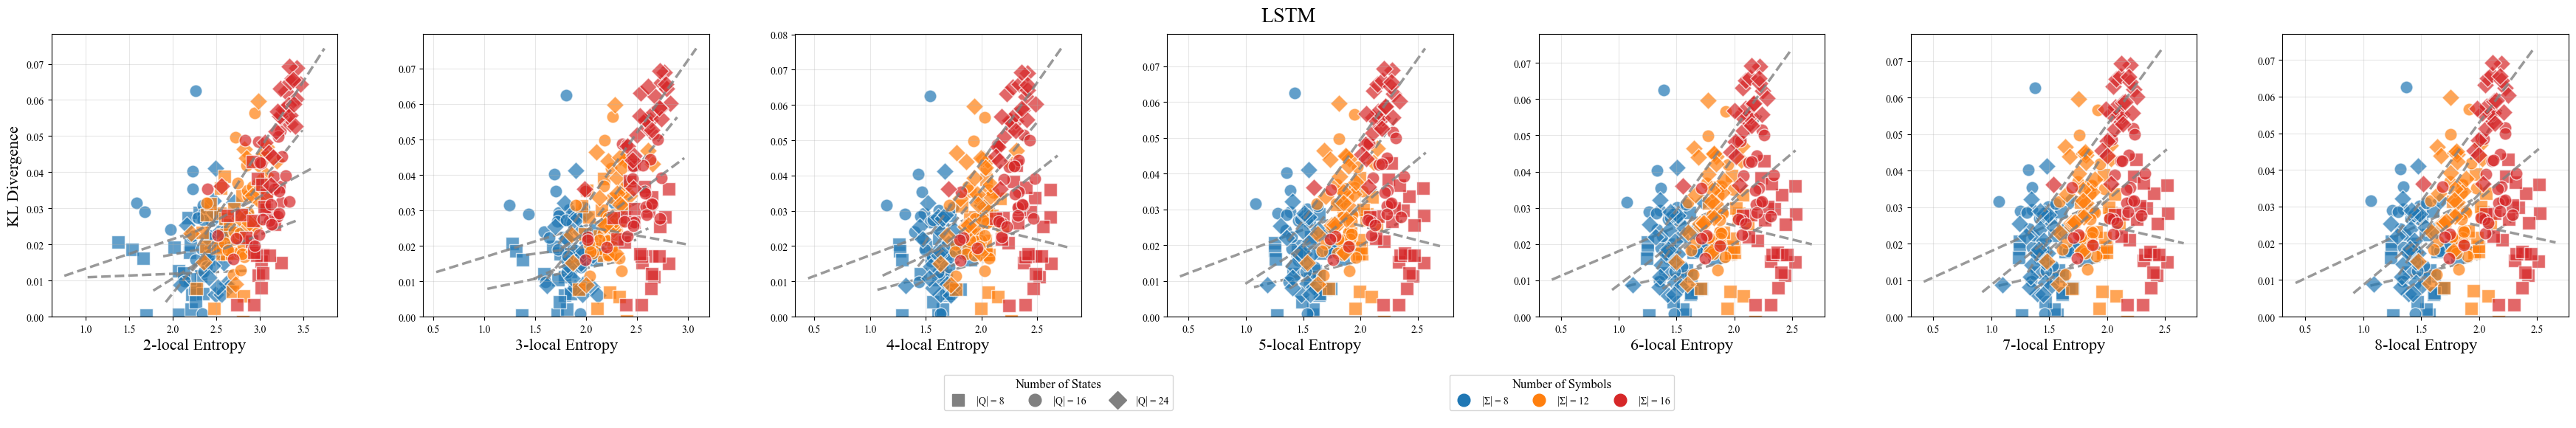

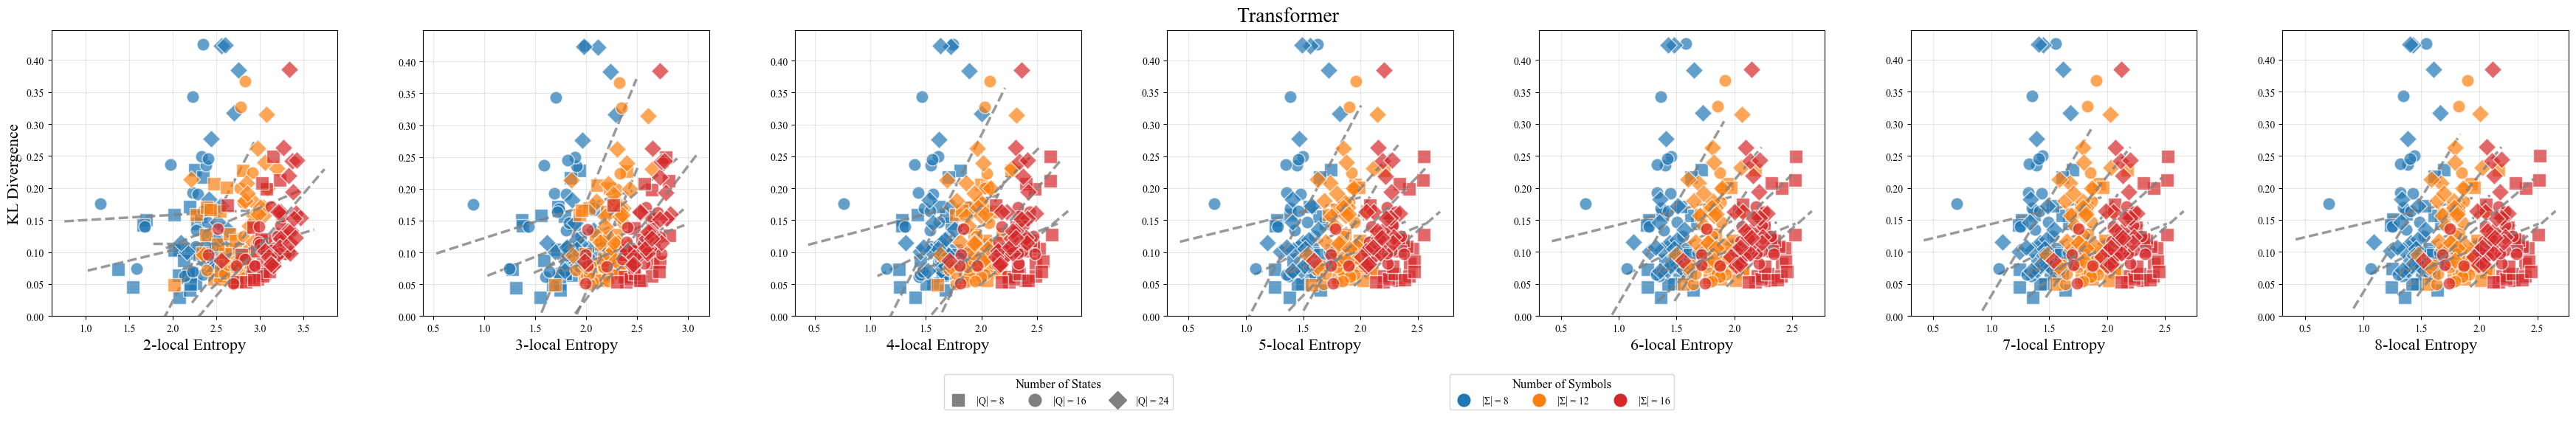

In [83]:
# Get m values from column names
ms = [
    int(col.replace("_local_entropy", ""))
    for col in df.columns
    if (col.endswith("_local_entropy") and not col.startswith("estimated_"))
]

# Define markers and colors for different parameters
n_states_markers = {
    8: "s",
    16: "o",  # 円
    24: "D",  # ダイヤモンド
}

n_sym_colors = {
    8: "#1f77b4",  # 濃い青
    12: "#ff7f0e",  # 濃い橙
    16: "#d62728",  # 濃い赤
}

# n_states_markers = {
#     16: "o",    # 円
#     24: "D",   # ダイヤモンド
#     32: "s",   # 四角

# }

# n_sym_colors = {
#     32: "#1f77b4",  # 濃い青
#     48: "#ff7f0e",  # 濃い橙
#     64: "#d62728",  # 濃い赤
# }

for architecture in df["architecture"].unique():
    model_data = df[df["architecture"] == architecture]

    # キャンバスのサイズを調整
    fig = plt.figure(figsize=(5 * len(ms), 6))

    # グリッドを作成（2行1列）：上部にプロット、下部に凡例
    gs = fig.add_gridspec(2, 1, height_ratios=[5, 1])

    # 上部のグリッドをさらにサブプロットに分割
    gs_top = gs[0].subgridspec(1, len(ms), wspace=0.3)
    axes = [fig.add_subplot(gs_top[0, i]) for i in range(len(ms))]

    for i, m in enumerate(ms):
        model_data_mean = (
            model_data.groupby(["grammar_name", "N_sym", "n_states"])
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "KL_divergence": "mean",
                }
            )
            .reset_index()
        )

        # Plot points and regression lines for each combination
        for n_sym in n_sym_colors.keys():
            for n_states in n_states_markers.keys():
                data = model_data_mean[
                    (model_data_mean["N_sym"] == n_sym)
                    & (model_data_mean["n_states"] == n_states)
                ]
                if not data.empty:
                    # Plot scatter points
                    axes[i].scatter(
                        data[f"{m}_local_entropy"],
                        data["KL_divergence"],
                        marker=n_states_markers[n_states],
                        color=n_sym_colors[n_sym],
                        s=150,
                        alpha=0.7,
                        edgecolor="white",
                        linewidth=1,
                    )

                    # Add regression line for this combination
                    x = data[f"{m}_local_entropy"]
                    y = data["KL_divergence"]
                    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

                    x_range = x.max() - x.min()
                    line_x = np.array(
                        [x.min() - 0.3 * x_range, x.max() + 0.3 * x_range]
                    )
                    line_y = slope * line_x + intercept
                    axes[i].plot(
                        line_x,
                        line_y,
                        color="gray",  # 統一した色
                        linestyle="--",
                        alpha=0.8,
                        linewidth=2.5,
                        zorder=1,
                    )

        axes[i].set_xlabel(f"{m}-local Entropy", fontsize=16)
        axes[i].set_ylabel("KL Divergence" if i == 0 else "", fontsize=16)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(
            0,
        )

    # 下部のグリッドに凡例を配置
    legend_ax = fig.add_subplot(gs[1])
    legend_ax.axis("off")  # 軸を非表示に

    # Create legend elements
    state_markers = [
        plt.Line2D(
            [0],
            [0],
            marker=marker,
            color="gray",
            markerfacecolor="gray",
            markersize=12,
            linestyle="None",
            label=f"|Q| = {n_states}",
        )
        for n_states, marker in n_states_markers.items()
    ]

    sym_markers = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color=color,
            markersize=12,
            linestyle="None",
            label=f"|Σ| = {n_sym}",
        )
        for n_sym, color in n_sym_colors.items()
    ]

    # Add legends side by side with horizontal arrangement of elements
    legend1 = legend_ax.legend(
        handles=state_markers,
        title="Number of States",
        loc="center",
        bbox_to_anchor=(0.4, 0.5),
        fontsize=10,
        title_fontsize=12,
        ncol=len(n_states_markers),
    )
    legend_ax.add_artist(legend1)

    legend2 = legend_ax.legend(
        handles=sym_markers,
        title="Number of Symbols",
        loc="center",
        bbox_to_anchor=(0.6, 0.5),
        fontsize=10,
        title_fontsize=12,
        ncol=len(n_sym_colors),
    )

    plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.96)
    plt.tight_layout()
    plt.show()

In [49]:
# Calculate R² values and create LaTeX table
results = []
for architecture in df["architecture"].unique():
    model_data = df[df["architecture"] == architecture]

    for m in ms:
        model_data_mean = (
            model_data.groupby(["grammar_name", "N_sym", "n_states"])
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "KL_divergence": "mean",
                }
            )
            .reset_index()
        )

        for n_sym in sorted(n_sym_colors.keys()):
            for n_states in sorted(n_states_markers.keys()):
                data = model_data_mean[
                    (model_data_mean["N_sym"] == n_sym)
                    & (model_data_mean["n_states"] == n_states)
                ]
                if not data.empty:
                    x = data[f"{m}_local_entropy"]
                    y = data["KL_divergence"]
                    _, _, r_value, _, _ = stats.linregress(x, y)
                    r_squared = r_value**2

                    results.append(
                        {
                            "Architecture": architecture_map[architecture],
                            "m": m,
                            "|Q|": n_states,
                            "|Σ|": n_sym,
                            "R²": r_squared,
                        }
                    )

results_df = pd.DataFrame(results)

# Create pivot table
pivot_df = results_df.pivot_table(
    index=["Architecture", "m"], columns=["|Q|", "|Σ|"], values="R²"
)

# Convert to LaTeX with specific formatting
latex_table = pivot_df.round(3).to_latex(
    multicolumn=True,
    multicolumn_format="c",
    bold_rows=True,
    float_format=lambda x: f"{x:.3f}" if pd.notnull(x) else "",
)

# Print LaTeX table
print(latex_table)

\begin{tabular}{llrrrrrrrrr}
\toprule
 & |Q| & \multicolumn{3}{c}{16} & \multicolumn{3}{c}{24} & \multicolumn{3}{c}{32} \\
 & |Σ| & 32 & 48 & 64 & 32 & 48 & 64 & 32 & 48 & 64 \\
Architecture & m &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{\textbf{LSTM}} & \textbf{2} & 0.433 & 0.501 & 0.137 & 0.291 & 0.583 & 0.121 & 0.423 & 0.311 & 0.623 \\
\textbf{} & \textbf{3} & 0.396 & 0.532 & 0.230 & 0.291 & 0.488 & 0.119 & 0.460 & 0.274 & 0.702 \\
\textbf{} & \textbf{4} & 0.412 & 0.546 & 0.236 & 0.311 & 0.477 & 0.122 & 0.474 & 0.283 & 0.702 \\
\textbf{} & \textbf{5} & 0.415 & 0.554 & 0.234 & 0.338 & 0.472 & 0.120 & 0.466 & 0.283 & 0.686 \\
\cline{1-11}
\multirow[t]{4}{*}{\textbf{Transformer}} & \textbf{2} & 0.740 & 0.679 & 0.455 & 0.290 & 0.658 & 0.844 & 0.551 & 0.622 & 0.709 \\
\textbf{} & \textbf{3} & 0.743 & 0.728 & 0.569 & 0.374 & 0.735 & 0.859 & 0.693 & 0.832 & 0.820 \\
\textbf{} & \textbf{4} & 0.737 & 0.674 & 0.549 & 0.389 & 0.727 & 0.844 & 0.668 & 0.848 & 0.799 \\
\textbf{} & 

## main figure


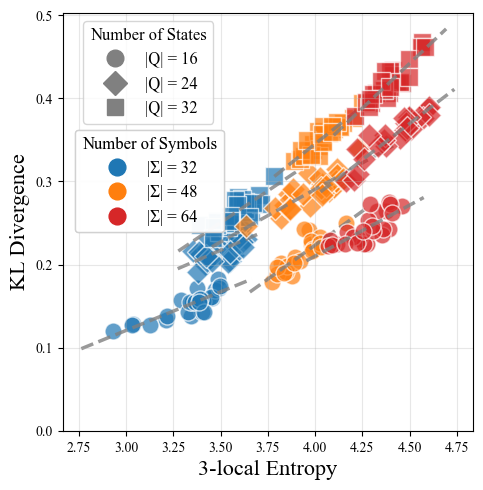

In [76]:
# Get m values from column names
# Set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

architecture = "transformer"
m = 3

ms = [
    int(col.replace("_local_entropy", ""))
    for col in df.columns
    if (col.endswith("_local_entropy") and not col.startswith("estimated_"))
]

# Define markers and colors for different parameters
n_states_markers = {
    16: "o",  # Circle
    24: "D",  # Diamond
    32: "s",  # Square
}

n_sym_colors = {
    32: "#1f77b4",  # Dark Blue
    48: "#ff7f0e",  # Dark Orange
    64: "#d62728",  # Dark Red
}

model_data = df[df["architecture"] == architecture]

model_data_mean = (
    model_data.groupby(["grammar_name", "N_sym", "n_states"])
    .agg(
        {
            f"{m}_local_entropy": "mean",
            "KL_divergence": "mean",
        }
    )
    .reset_index()
)

plt.figure(figsize=(5, 5))

# Plot points and regression lines for each combination
for n_sym in n_sym_colors.keys():
    for n_states in n_states_markers.keys():
        data = model_data_mean[
            (model_data_mean["N_sym"] == n_sym)
            & (model_data_mean["n_states"] == n_states)
        ]
        if not data.empty:
            # Calculate IQR for KL_divergence
            Q1_y, Q3_y = np.percentile(data["KL_divergence"], [25, 75])
            IQR_y = Q3_y - Q1_y
            lower_bound_y = Q1_y - 1.5 * IQR_y
            upper_bound_y = Q3_y + 1.5 * IQR_y

            # Filter out outliers
            mask = (data["KL_divergence"] >= lower_bound_y) & (
                data["KL_divergence"] <= upper_bound_y
            )
            filtered_data = data[mask]

            if not filtered_data.empty:
                # Plot scatter points
                plt.scatter(
                    filtered_data[f"{m}_local_entropy"],
                    filtered_data["KL_divergence"],
                    marker=n_states_markers[n_states],
                    color=n_sym_colors[n_sym],
                    s=150,
                    alpha=0.7,
                    edgecolor="white",
                    linewidth=1,
                )

                # Add regression line for this combination
                x = filtered_data[f"{m}_local_entropy"]
                y = filtered_data["KL_divergence"]
                if len(x) > 2:  # Need at least 3 points for meaningful regression
                    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                    x_range = x.max() - x.min()
                    line_x = np.array(
                        [x.min() - 0.3 * x_range, x.max() + 0.3 * x_range]
                    )
                    line_y = slope * line_x + intercept
                    plt.plot(
                        line_x,
                        line_y,
                        color="gray",
                        linestyle="--",
                        alpha=0.8,
                        linewidth=2.5,
                        zorder=1,
                    )

state_markers = [
    plt.Line2D(
        [0],
        [0],
        marker=marker,
        color="gray",
        markerfacecolor="gray",
        markersize=12,  # Smaller marker size
        linestyle="None",
        label=f"|Q| = {n_states}",
    )
    for n_states, marker in n_states_markers.items()
]

sym_markers = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color=color,
        markersize=12,  # Smaller marker size
        linestyle="None",
        label=f"|Σ| = {n_sym}",
    )
    for n_sym, color in n_sym_colors.items()
]

# Add legends inside the figure ensuring they don't overlap
legend1 = plt.legend(
    handles=state_markers,
    title="Number of States",
    loc="upper left",
    bbox_to_anchor=(0.03, 1),
    fontsize=12,  # Smaller font size
    title_fontsize=12,  # Smaller title font size
    ncol=1,
)  # Set number of columns to 1

legend2 = plt.legend(
    handles=sym_markers,
    title="Number of Symbols",
    loc="upper left",
    bbox_to_anchor=(0.01, 0.74),  # Adjusted to prevent overlap
    fontsize=12,  # Smaller font size
    title_fontsize=12,  # Smaller title font size
    ncol=1,
)  # Set number of columns to 1

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.grid(True, alpha=0.3)
plt.xlabel(f"{m}-local Entropy", fontsize=16)
plt.ylabel("KL Divergence", fontsize=16)
# plt.title("Relationship between Local Entropy and KL Divergence", fontsize=18)  # Added figure title
plt.tight_layout()
plt.ylim(
    0,
)
plt.show()